In [105]:
#initial filtering code
import pandas as pd
import numpy as np
df = pd.read_csv('Data/archive_data_15.01.26.csv', comment='#')

# see first few rows of 'archive data' 
useful_columns_only = df[['pl_name', 'pl_orbper', 'pl_orbsmax', 'pl_masse', 'pl_rade',
                'pl_trandep', 'pl_trandur', 'pl_orbeccen', 'pl_orbincl', 'st_rad', 
                'st_mass', 'st_teff', 'pl_ratror','sy_jmag', 'discoverymethod', 'default_flag']]

# filter for default parameter rows only
default_planets = useful_columns_only[useful_columns_only['default_flag'] == 1]

# set size limits for filtering
radius_lower = 1.5 # earth radii
radius_upper = 4 

# filter for planets in size limits
filtered_sizes = default_planets[
    (default_planets['pl_rade'] >= radius_lower) &
    (default_planets['pl_rade'] <= radius_upper)
]

# checks
print('initial downloaded table dimensions:', df.shape)
print('column filtered table dimensions:', useful_columns_only.shape)
print('default planets table dimensions:', default_planets.shape)
print('size filtered table dimensions:', filtered_sizes.shape)
filtered_sizes.head()


initial downloaded table dimensions: (39235, 111)
column filtered table dimensions: (39235, 16)
default planets table dimensions: (6071, 16)
size filtered table dimensions: (2467, 16)


,pl_name,pl_orbper,pl_orbsmax,pl_masse,pl_rade,pl_trandep,pl_trandur,pl_orbeccen,pl_orbincl,st_rad,st_mass,st_teff,pl_ratror,sy_jmag,discoverymethod,default_flag
125,55 Cnc e,0.736547,0.01544,7.9900,1.875000,NaN,NaN,0.05000,83.59000,0.943,0.905,5172.0,0.0182,4.768000,Radial Velocity,1
176,AU Mic b,8.463080,0.06490,NaN,3.956770,0.2379,3.4927,0.00577,89.57917,0.744,0.510,3678.0,0.0488,5.436000,Transit,1
187,AU Mic c,18.859690,0.11080,NaN,2.522021,0.0970,4.2360,0.00338,89.22655,0.744,0.510,3678.0,0.0311,5.436000,Transit,1
205,BD+20 594 b,41.685500,NaN,22.2481,2.578070,0.0490,NaN,0.00000,89.55000,1.080,1.670,5766.0,NaN,9.770001,Transit,1
336,CoRoT-24 b,5.113400,0.05600,5.7000,3.700000,NaN,2.8500,0.00000,86.50000,0.860,0.910,4950.0,0.0370,13.595000,Transit,1


In [106]:
# filtered_sizes.to_csv('filtered_exoplanets.csv', index=False)   

### Calculating T_eq
might as well calculate the TSM for each one (or filter those we can't calc for? not for now.)
- needs equilibrium temperature first
- also remember to check how much 0 vs 0.3 albedo changes things

$T_{eq} = T_{star} * \sqrt{\frac{R_{star}}{2a}} * (1 - A)^{\frac{1}{4}}$

in code form is 

T_eq = T_star * (R_star / 2a)**0.5 * (1 - A))**0.25

In [107]:
# function to calculate equilibrium temperature

def calc_Teq(T_star, R_star, a_AU, A=0):
    """Calculates eq temp (assuming full heat redistribution)
    T_star : stellar temp in Kelvin
    R_star : stellar R in R_sun
    a_AU   : orbital semi-major axis [AU]
    A      : bond albedo (default 0)
    """
    a_Rsun = a_AU * 215.032  # need matching units
    return T_star * (R_star / (2*a_Rsun))**0.5 * (1 - A)**0.25

In [108]:
fs_with_Teq = filtered_sizes.copy()
fs_with_Teq['pl_Teq'] = calc_Teq(
    fs_with_Teq['st_teff'],
    fs_with_Teq['st_rad'],
    fs_with_Teq['pl_orbsmax'],
    A=0.3
)
fs_with_Teq[['pl_name','st_teff','st_rad','pl_orbsmax','sy_jmag','pl_Teq']].head()

,pl_name,st_teff,st_rad,pl_orbsmax,sy_jmag,pl_Teq
125,55 Cnc e,5172.0,0.943,0.01544,4.768000,1782.783802
176,AU Mic b,3678.0,0.744,0.06490,5.436000,549.267382
187,AU Mic c,3678.0,0.744,0.11080,5.436000,420.374417
205,BD+20 594 b,5766.0,1.080,NaN,9.770001,NaN
336,CoRoT-24 b,4950.0,0.860,0.05600,13.595000,855.595272


##### Check how many T_eq not NaN
Lovely. how many of these can we actually get Eq temp for?

In [109]:
print('with all rows:',fs_with_Teq.shape)
fs_with_Teq.dropna(subset=['pl_Teq']).shape
print('with only rows with value for Teq:',fs_with_Teq.dropna(subset=['pl_Teq']).shape)

with all rows: (2467, 17)
with only rows with value for Teq: (1094, 17)


Wayyyyy less. Okay, is this standard?
Also, should we be dismissing the rows that don't have the essentials in anyway? What are the essentials?

Will need to hear from team 1 what they need. can further filter easily, by changing the initial list in the first code block. Nothing done here is permanent, can just run again with whatever initial is needed. In this case dismissing rows for now is unneccesary, and will do the TSM now.

### Calculating TSM

$$\text{TSM} = \text{SF} \times \frac{R_p^3 \, T_\mathrm{eq}}{M_p \, R_*^2} \times 10^{-m_J/5}$$


TSM includes **scale factor** which 'is a normalization constant and also is responsible for unit conversion. Determined separately based on planet radius bin.'

Paper uses scale factor of 1.26 for 1.5-2.75 R_earth planets, and 1.28 for 2.75-4.0 R_earth planets.
Using 1.27 for now.

In [110]:
def calc_TSM(R_p, M_p, T_eq, R_star, mJ=9.5, scale_factor=1.27):
    """Calculates Transmission Spectroscopy Metric (TSM) from Kempton+2018
    R_p : planet radius (R_earth)
    M_p : planet mass (M_earth)
    T_eq: planet eq temp in K
    R_star: units of R_sun
    mJ  : J-band magnitude of host star 
    scale_factor: depends on planet size regime (See Kempton+2018 for some values)
    """
    TSM = (scale_factor * (R_p**3 * T_eq) / (M_p * R_star**2) * 10**(-mJ/5))
    return TSM


In [111]:
# maybe cos of scale factor, not best to compute whole table at once? can come back to later. 

fs_with_TSM = fs_with_Teq.copy()
fs_with_TSM['pl_tsm'] = calc_TSM(
    fs_with_TSM['pl_rade'],
    fs_with_TSM['pl_masse'],
    fs_with_TSM['pl_Teq'],
    fs_with_TSM['st_rad'],
    fs_with_TSM['sy_jmag'],  # 2MASS J-mag
    scale_factor=1.27  # placeholder value; adjust based on planet size regime
)
fs_with_TSM[['pl_name','pl_rade','pl_masse','pl_Teq','st_rad','sy_jmag','pl_tsm']].head()
#fs_with_TSM.head(20)

,pl_name,pl_rade,pl_masse,pl_Teq,st_rad,sy_jmag,pl_tsm
125,55 Cnc e,1.875000,7.9900,1782.783802,0.943,4.768000,233.741621
176,AU Mic b,3.956770,NaN,549.267382,0.744,5.436000,NaN
187,AU Mic c,2.522021,NaN,420.374417,0.744,5.436000,NaN
205,BD+20 594 b,2.578070,22.2481,NaN,1.080,9.770001,NaN
336,CoRoT-24 b,3.700000,5.7000,855.595272,0.860,13.595000,24.934778


##### Check how many TSM not NaN
Nice! Now how many of these actually have TSM values (hopefully not much less than those with T_eq)?

In [112]:
print('with all rows:',fs_with_TSM.shape)
fs_with_TSM.dropna(subset=['pl_tsm']).shape
print('with only rows with value for Teq:',fs_with_Teq.dropna(subset=['pl_Teq']).shape)
print('with only rows with value for TSM:',fs_with_TSM.dropna(subset=['pl_tsm']).shape)

with all rows: (2467, 18)
with only rows with value for Teq: (1094, 17)
with only rows with value for TSM: (306, 18)


##### Initial TSM histogram
Well that narrows it down a bit. Archie notes - paper describes 300 high quality targets over large radius (inc > R_nep), and we have 300 of any quality. Maybe histogram the TSM?


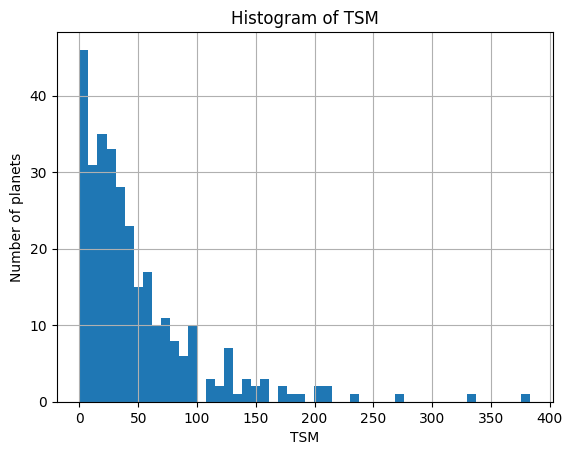

In [ ]:
import matplotlib.pyplot as plt

fs_with_TSM['pl_tsm'].hist(bins=50) 
plt.xlabel('TSM')
plt.ylabel('Number of planets')
plt.title('Histogram of TSM')
plt.show()
# checked and this ignores NaNs automatically

Seems to be in a normal range, although paper gave ranges that look a bit out.

In [114]:
fs_with_TSM[['pl_name','pl_rade','pl_masse','pl_Teq','st_rad','sy_jmag','pl_tsm']].dropna(subset=['pl_tsm']).head(20)

,pl_name,pl_rade,pl_masse,pl_Teq,st_rad,sy_jmag,pl_tsm
125,55 Cnc e,1.875,7.99,1782.783802,0.9430,4.768,233.741621
336,CoRoT-24 b,3.700,5.70,855.595272,0.8600,13.595,24.934778
417,EPIC 201595106 b,1.565,7.67,1863.829745,0.9800,10.588,9.395188
503,EPIC 220674823 b,1.676,7.80,2135.533505,0.9900,10.770,11.715671
516,EPIC 220674823 c,2.840,7.32,747.315881,0.9900,10.770,21.255997
526,EPIC 229004835 b,2.332,10.40,735.522503,0.9990,9.061,17.588184
534,EPIC 249893012 b,1.950,8.75,1444.630969,1.7100,10.216,4.813536
535,EPIC 249893012 c,3.670,14.67,868.628698,1.7100,10.216,11.508368
536,EPIC 249893012 d,3.940,10.18,667.720192,1.7100,10.216,15.774184
550,G 9-40 b,1.900,4.00,402.897029,0.3026,10.058,93.295511


Maybe it's just EPIC causing problems?

In [ ]:
# this is for comparison with the 2018 paper quartiles which seem to be a lot higher (and they split our range into 2 categories!)
# Sort all planets by TSM descending
top_100 = fs_with_TSM.sort_values(by='pl_tsm', ascending=False).head(100)

# Compute quartiles of these top 100 planets
quartiles_top100 = top_100['pl_tsm'].quantile([0, 0.25, 0.50, 0.75])
print(quartiles_top100) 

0.00     49.875200
0.25     62.578652
0.50     83.464029
0.75    123.828890
Name: pl_tsm, dtype: float64


In [116]:
print('with all rows:',fs_with_TSM.shape)
fs_with_TSM.dropna(subset=['pl_tsm']).shape
print('with only rows with value for Teq:',fs_with_Teq.dropna(subset=['pl_Teq']).shape)
print('with only rows with value for TSM:',fs_with_TSM.dropna(subset=['pl_tsm']).shape)

with all rows: (2467, 18)
with only rows with value for Teq: (1094, 17)
with only rows with value for TSM: (306, 18)


##### What data is missing?

In [117]:
# columns needed for TSM + Teq
required_cols = ['pl_rade', 'pl_masse', 'pl_Teq', 'st_rad', 'sy_jmag', 'st_teff', 'pl_orbsmax']

missing_counts = fs_with_TSM[required_cols].isna().sum()
print(missing_counts)



pl_rade          0
pl_masse      2030
pl_Teq        1373
st_rad          12
sy_jmag          1
st_teff         54
pl_orbsmax    1360
dtype: int64


### Estimating empty P_Masses
Need to fill masses. Paper in 2018 describes relation, but more recent 2023 paper by muller describes small, intermediate, and massive mass planets with the following relation: 
$$ R = \begin{cases} (1.02 \pm 0.03)M^{(0.27 \pm 0.04)} & M < (4.37 \pm 0.72) \\ (0.56 \pm 0.03)M^{(0.67 \pm 0.05)} & (4.37 \pm 0.72) < M < (127 \pm 7) \\ (18.6 \pm 6.7)M^{(-0.06 \pm 0.07)} & M > (127 \pm 7) \end{cases} $$
Rearranging for R we can define function that uses this to fill in masses, and then plot calculated against real and missing to see how good it is (cos for trends, doesn't have to be perfect - i think (will ask)). Muller defines intermediate starting at ~1.6R_earth

In [118]:
def estimate_mass_muller(Rp):
    """
    Estimate planet mass from radius (earth units) using Muller 2024 relation
    """
    return np.where(
        Rp <= 1.6, (Rp / 1.02)**(1/0.27),
        np.where(Rp <= 4.0, (Rp / 0.56)**(1/0.67),
                 (Rp / 18.6)**(1/(-0.06)))
    )


In [119]:
#create new column with all estimated masses
fs_with_Teq['pl_masse_est'] = estimate_mass_muller(fs_with_Teq['pl_rade'])

#replace missing masses with corresponding estimated mass
fs_with_Teq['pl_masse_filled'] = fs_with_Teq['pl_masse'].fillna(
    fs_with_Teq['pl_masse_est']
)

In [120]:
# copy for ease
df = fs_with_Teq.copy()
df[['pl_masse', 'pl_masse_est', 'pl_masse_filled']].head(10)

,pl_masse,pl_masse_est,pl_masse_filled
125,7.990000,6.071603,7.990000
176,NaN,18.509396,18.509396
187,NaN,9.450692,9.450692
205,22.248100,9.765882,22.248100
336,5.700000,16.745613,5.700000
376,4.076605,5.159908,4.076605
414,NaN,6.047453,6.047453
415,NaN,4.171933,4.171933
417,7.670000,4.881699,7.670000
432,NaN,5.245566,5.245566


##### Plot comparing estimated vs actual

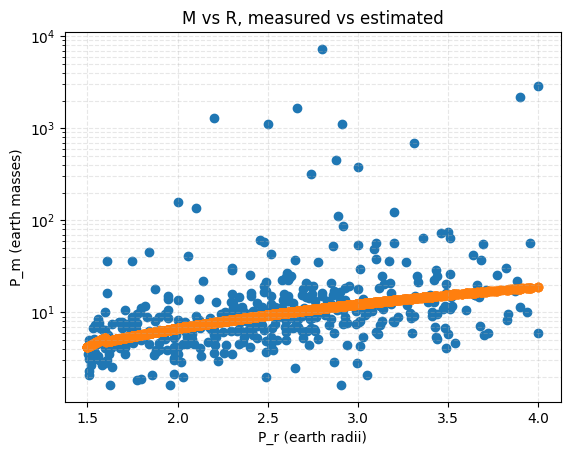

In [121]:
import matplotlib.pyplot as plt



plt.scatter(df['pl_rade'], df['pl_masse'])
plt.scatter(df['pl_rade'], df['pl_masse_est'])
plt.xlabel('P_r (earth radii)')
plt.ylabel('P_m (earth masses)')
plt.title('M vs R, measured vs estimated')
plt.yscale('log')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.show()


### recalc TSM with filled masses
Not bad. Now can use 'pl_masse_filled' for TSM calculations, and see how many more we get.

For now, until one or other decided, will label new df fs_with_TSM2, and calculate TSM again from fs_with_Teq that now has 'pl_masse_filled' 

In [ ]:
fs_with_TSM2 = fs_with_Teq.copy()
fs_with_TSM2['pl_tsm2'] = calc_TSM(
    fs_with_TSM2['pl_rade'],
    fs_with_TSM2['pl_masse_filled'],
    fs_with_TSM2['pl_Teq'],
    fs_with_TSM2['st_rad'],
    fs_with_TSM2['sy_jmag'],  # 2MASS J-mag
    scale_factor=1.27  # placeholder value; adjust based on planet size regime
)
fs_with_TSM2[['pl_name','pl_rade','pl_masse_filled','pl_Teq','st_rad','sy_jmag','pl_tsm2']].head()
#fs_with_TSM2.head(20)

,pl_name,pl_rade,pl_masse_filled,pl_Teq,st_rad,sy_jmag,pl_tsm2
125,55 Cnc e,1.875000,7.990000,1782.783802,0.943,4.768000,233.741621
176,AU Mic b,3.956770,18.509396,549.267382,0.744,5.436000,345.041952
187,AU Mic c,2.522021,9.450692,420.374417,0.744,5.436000,133.929561
205,BD+20 594 b,2.578070,22.248100,NaN,1.080,9.770001,NaN
336,CoRoT-24 b,3.700000,5.700000,855.595272,0.860,13.595000,24.934778


In [124]:
#check if we have more planets with TSM now!
print('with all rows:',fs_with_TSM2.shape)
fs_with_TSM2.dropna(subset=['pl_tsm2']).shape
print('with only rows with value for Teq:',fs_with_Teq.dropna(subset=['pl_Teq']).shape)
print('with only rows with value for TSM:',fs_with_TSM2.dropna(subset=['pl_tsm2']).shape)

with all rows: (2467, 20)
with only rows with value for Teq: (1094, 19)
with only rows with value for TSM: (1093, 20)


#### Comparing old vs recalc TSM 
(not different just increased counts)
Hell yeah. Before had 306, now 1093 after filling in missing masses. Still limited by Teq missing values though. Leave for now. What do the histogram and quartiles look like now?

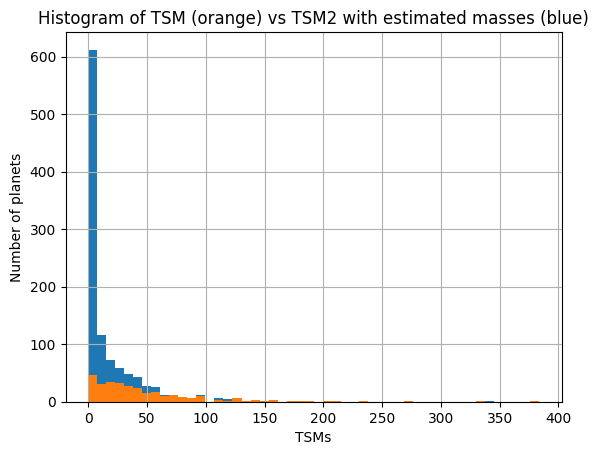

In [128]:
fs_with_TSM2['pl_tsm2'].hist(bins=50) 
fs_with_TSM['pl_tsm'].hist(bins=50) 
plt.xlabel('TSMs')
plt.ylabel('Number of planets')
plt.title('Histogram of TSM (orange) vs TSM2 with estimated masses (blue)')
plt.show()
# checked and this ignores NaNs automatically

Ngl don't seem to be that many more good ones. Tbf, $TSM \propto 1/M_p$ so maybe the estimated masses by missing the smaller masses (see graph of measured vs estimated) are having a larger effect in one direction

In [ ]:
#copying earlier quartile code for TSM2
# this is for comparison with the 2018 paper quartiles which seem to be a lot higher (and they split our range into 2 categories!)
# Sort all planets by TSM descending
top_100 = fs_with_TSM2.sort_values(by='pl_tsm2', ascending=False).head(100)

# Compute quartiles of these top 100 planets
quartiles_top100 = top_100['pl_tsm2'].quantile([0, 0.25, 0.50, 0.75])
print(quartiles_top100) 

0.00     57.345601
0.25     70.769264
0.50     92.816179
0.75    126.203421
Name: pl_tsm2, dtype: float64


This is BARELY better! Are all the good planets the ones missing orbsmax and therefore Teq? (don't discount effect of merely estimated masses - discuss with group + anjali/jenny)

Ah. Also, 'most planets missing masses tend to be smaller, less well-characterized planets (because larger planets are easier to measure)' thanks chatgpt I was being dumb.

Time to fill in the orbsmax column using keplers third law?